# Testing package `Whirl2d`

In [574]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body

In [575]:
Npts = 100
len = 1
xcent = [0.0,0.0]
ang = π/2
b = Bodies.Plate(Npts,len,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [6.12323e-17 -1.0; 1.0 6.12323e-17]


### Create a domain with this body in it

In [576]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [6.12323e-17 -1.0; 1.0 6.12323e-17]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [577]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [6.12323e-17 -1.0; 1.0 6.12323e-17]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [578]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,0.5*Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([1.0, 0.0, 0.0], 200.0), 0.125)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [570]:
@time ops = NavierStokes.set_operators_body!(dom,params);

  1.483871 seconds (1.84 M allocations: 118.318 MiB, 4.95% gc time)


### Create an initial solution structure

In [571]:
s = NavierStokes.BodySoln(dom)
A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Advance the solution

In [573]:
for i = 1:1
    @time s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s

Solution: t = 0.1


  0.566636 seconds (318.91 k allocations: 14.597 MiB, 2.24% gc time)


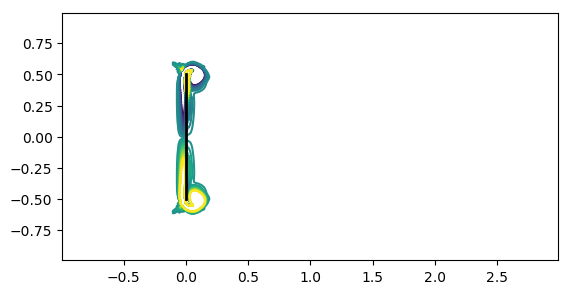

(-0.995, 2.995, -0.995, 0.9950000000000001)

In [496]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    plot(xpt,ypt,color="k",linewidth=2)
end
axis("scaled")

In [474]:
dom.Eᵀ[1]'*ones(length(dom.grid.facex))

100-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

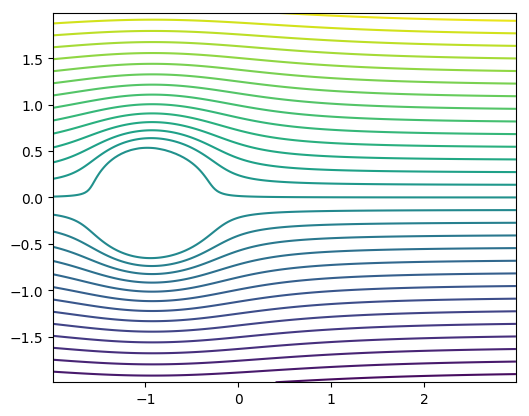

(-1.99, 2.99, -1.99, 1.9900000000000002)

In [364]:
s.ψ = -Grids.L⁻¹(dom.grid,s.u)
contour(x,y,s.ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx+y,linspace(-2,2,31))
axis("scaled")

In [456]:
s.u

402×202 Array{Float64,2}:
 -1.03759e-16  -5.0956e-17   -7.3002e-17   …  -1.13357e-17  -7.86485e-17
 -1.03852e-16  -2.45642e-17  -1.13679e-16     -6.3197e-17   -1.32064e-16
 -2.59924e-17   1.64047e-17  -1.23999e-16     -1.64246e-16  -1.62659e-16
 -1.65695e-17   4.15069e-17  -2.635e-17       -1.15283e-16  -1.12237e-16
 -3.4985e-17    7.41999e-17   7.67867e-17     -7.80031e-17  -1.21235e-16
  2.9077e-17    1.01826e-16   1.10751e-16  …  -1.96836e-16  -9.94132e-17
  2.74341e-17   1.0266e-16    3.13139e-17     -8.37548e-17  -3.89672e-17
  1.97482e-17   2.78567e-17  -5.43332e-17     -9.06538e-17  -5.4101e-17 
  1.05181e-16   5.17143e-17   4.05522e-17     -3.11608e-17   1.45278e-17
  1.44481e-16   1.57412e-16   6.87917e-17     -1.40821e-17  -1.18338e-17
 -2.49562e-17   1.21196e-17  -5.61814e-17  …  -3.19276e-17  -2.41624e-17
 -1.43142e-16  -6.6095e-17   -8.09183e-17      6.36315e-18   4.52583e-18
 -1.54381e-16  -7.51837e-17  -5.93074e-17     -1.32933e-17  -2.49723e-17
  ⋮                      

Plot the C<sup>T</sup> E<sub>y</sub><sup>T</sup> operator

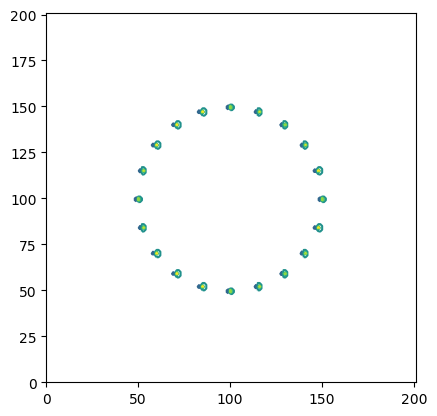

(0.0, 201.0, 0.0, 201.0)

In [190]:
contour(reshape(dom.ECᵀ[1]*ones(dom.nbodypts),size(dom.grid.cell)))
axis("scaled")

In [15]:
# Create a "grid unit vector": a bunch of cell data with zeros everywhere except at one point.
# This is useful for visualizing the LGF and the integrating factor
wunit = zeros(dom.grid.cell);
wunit[40,40] = 1.0;

In [192]:
# This is the discrete convolution of the integrating factor with the grid unit vector
# The result is just the integrating factor field, but shifted to the center specified
# in the grid unit vector.
@time s = Grids.Q(dom.grid,wunit);

  0.037541 seconds (264.80 k allocations: 14.863 MiB, 13.88% gc time)


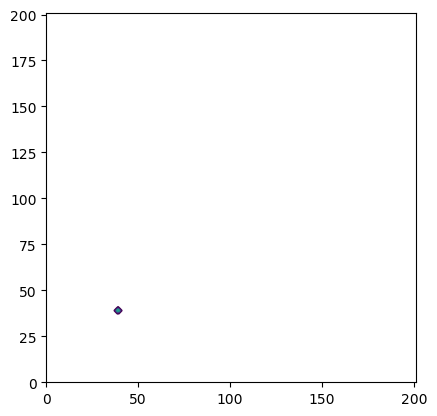

(0.0, 201.0, 0.0, 201.0)

In [193]:
# plot this
contour(s,linspace(0.01,1,31))
axis("scaled")

In [194]:
# This is the discrete convolution of the LGF with the grid unit vector
@time s = Grids.L⁻¹(dom.grid,wunit);

  0.022773 seconds (245.24 k allocations: 13.999 MiB)


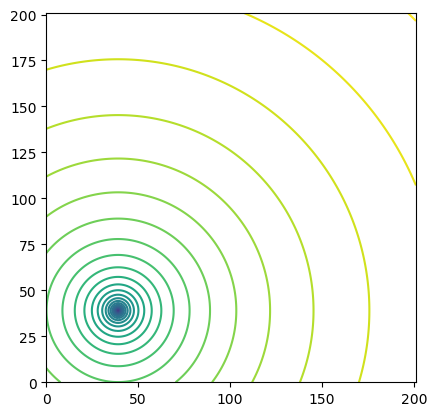

(0.0, 201.0, 0.0, 201.0)

In [195]:
# plot this
contour(s,31)
axis("scaled")